# Quantum superdense coding in SQUANCH

In [2]:
import numpy as np
import time 
import matplotlib.image as image
import matplotlib.pyplot as plt
from squanch.agent import *
from squanch.gates import *
from squanch.qstream import *

We'll be implementing the following circuit diagram of superdense information transmission. Charlie will distribute Bell pairs to Alice, who will send a bitstream of an image, and Bob, who will receive and reconstruct Alice's information. Any dropped qubits lost to attenuation will have their bits replaced with 0.

![Superdense coding circuit](https://upload.wikimedia.org/wikipedia/commons/b/b7/Superdense_coding.png)

In [3]:
class Alice(Agent):
    '''Alice sends information to Bob via superdense coding'''
    def run(self):
        for i in range(len(self.stream)):
            bit1, bit2 = self.data[2 * i], self.data[2 * i + 1]
            q = self.qrecv(charlie)
            if q is not None:
                if bit2 == 1: X(q)
                if bit1 == 1: Z(q)
            self.qsend(bob, q)

class Bob(Agent):
    '''Bob receives Alice's transmissions and reconstructs her information'''
    def run(self):
        self.data = np.zeros(2 * len(self.stream), dtype = np.uint8)
        for i in range(len(self.stream)):
            a = self.qrecv(alice)
            c = self.qrecv(charlie)
            if a is not None and c is not None:
                CNOT(a, c)
                H(a)
                self.data[2 * i] = a.measure()
                self.data[2 * i + 1] = c.measure()
        self.output(self.data)

class Charlie(Agent):
    '''Charlie distributes Bell pairs between Alice and Bob.'''
    def run(self):
        for qSys in self.stream:
            a, b = qSys.qubits
            H(a)
            CNOT(a, b)
            self.qsend(alice, a)
            self.qsend(bob, b)

Transmitted 414720 bits in 26.627s.


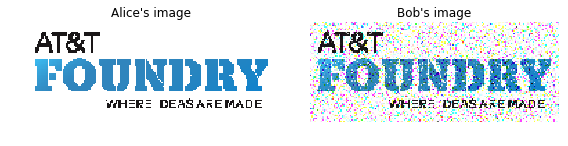

In [4]:
# Load an image and serialize it to a bitstream
imgArray = image.imread("img/foundryLogo.bmp")
imgBitstream = np.unpackbits(imgArray)

# Allocate a shared Hilbert space and output object to pass to agents
mem = sharedHilbertSpace(2, len(imgBitstream) / 2)
out = sharedOutputDict()

# Make agent instances
alice = Alice(mem, data = imgBitstream)
bob = Bob(mem, out = out)
charlie = Charlie(mem)
# Connect the agents over simulated fiber optic lines
connectAgents(alice, bob, length = 1.0)
connectAgents(alice, charlie, length = 0.5)
connectAgents(bob, charlie, length = 0.5)
# Run the agents
start = time.time()
agents = [alice, bob, charlie]
[agent.start() for agent in agents]
[agent.join() for agent in agents] 
print "Transmitted {} bits in {:.3f}s.".format(len(out["Bob"]), time.time() - start)

receivedArray = np.reshape(np.packbits(out["Bob"]), imgArray.shape)
f, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].imshow(imgArray)
ax[0].axis('off')
ax[0].title.set_text("Alice's image")
ax[1].imshow(receivedArray)
ax[1].axis('off')
ax[1].title.set_text("Bob's image")
plt.tight_layout()
plt.show()